In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
import emcee
import corner

Start by using the Rosenbrock function as the negative log-likelihood:

In [2]:
def rosenbrock_neg_log_likelihood(params, a=1, b=100):
    """
    Negative Log-likelihood function given by the negative of the Rosenbrock function
    param params: tuple of (x, y) as the inputs to the rosenbrock function,
    which is:
    
    f(x,y)=(a-x)^{2}+b(y-x^{2})^{2}
    
    where we use a=1, b=100 as default parameters
    """
    x, y = params  # params is tuple of 2 numbers
    # Use the rosenbrock function as our log-likelihood
    log_likelihood = ((a - x) ** 2) + (b * (y - x ** 2) ** 2)
    # return the negative log-likelihood
    return -log_likelihood

Test to make sure the Rosenbrock function is actually being plotted as suggested:

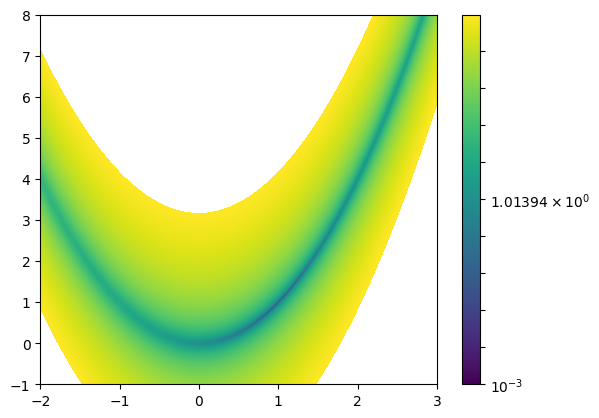

In [3]:
npoints = 500

# bounds of our sampling
x_lower = -2
x_upper = 3
y_lower = -1
y_upper = 8

testarr = np.zeros((npoints, npoints))
X, Y = np.meshgrid(np.linspace(x_lower, x_upper, npoints), np.linspace(y_lower, y_upper, npoints))

for i in range(0, len(X)):
    for j in range(0, len(Y)):
        testarr[i, j] = -rosenbrock_neg_log_likelihood((X[i, j], Y[i, j]))  # negative of neg log likelihood

# plot
plt.contourf(X, Y, testarr, levels=np.logspace(-3, 3, npoints), norm = LogNorm())
plt.colorbar()
plt.show()

Define a prior that is uniform over $x = \left[-2, 3\right]$, $y = \left[-1, 8\right]$ that is $0$ everywhere else, and a log probability as `log_prior` + `neg_log_likelihood`:

In [4]:
def rosenbrock_log_prior(params, x_min=x_lower, x_max=x_upper, y_min=y_lower, y_max=y_upper):
    """
    Log prior that is uniform over x = (-2, 3), y = (-1, 8) and 0 outside of that range
    """
    # params are x and y
    x, y = params
    # if they fall within [-2, 2], [-1, 8] uniform prior, otherwise 0 outside that range
    if (x_min <= x <= x_max and y_min <= y <= y_max):
        return 0.  # log prior, so ln(1) = 0
    else:
        return -np.inf  # log prior, so ln(0) = -infinity
    
    
def rosenbrock_log_probability(params):
    # get the log prior for the params
    rosenbrock_lp = rosenbrock_log_prior(params)
    # negative infinity (log(0)) if outside [-2, 3], [-1, 8] as detected by log prior
    if not np.isfinite(rosenbrock_lp):
        return -np.inf
    # otherwise, log prob is log prior + log likelihood
    return rosenbrock_lp + rosenbrock_neg_log_likelihood(params)

Now set up the MCMC (use $50$ walkers with $50000$ steps) just to check. The starting position of our walkers is drawn from a small Gaussian distribution ($\sigma = 0.01$) around the global minimum $[-1, 1]$:

In [5]:
nwalkers = 50  # nubmer of walkers to use in the MCMC
ndim = 2  # 2 dimensions for our rosenbrock function
seed = 1234  # seed to use for picking a random point
nsteps = 50000  # number of mcmc steps to take

# choose the global minimum [-1, 1] as our starting position 
# and see if the chains are still well-mixed
np.random.seed(seed)  # set the seed

pos = np.random.multivariate_normal((1, 1), cov = np.diag([0.01, 0.01], k=0), size = nwalkers)  # Gaussian ball, 0.01 chosen arbitrarily

# setting up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, rosenbrock_log_probability)

And run the sampler:

In [ ]:
sampler.run_mcmc(pos, nsteps, progress=True)

 63%|██████▎   | 31569/50000 [00:30<00:18, 974.77it/s] 

Get the samples as a chain:

In [ ]:
burnin=200  # number of burnin samples to discard

samples = sampler.get_chain()[burnin:]  # discard the first 200 samples ("burn-in" time for the chains to be well-mixed)
# split into x and y samples
x_samples = samples[:, :, 0]
y_samples = samples[:, :, 1]

2D histogram of the sampled distribution:

In [ ]:
plt.figure(figsize = (12, 8))
corner.hist2d(x_samples.reshape(-1), y_samples.reshape(-1), s=0.1, bins=200, plot_datapoints=False, plot_density=False, levels=[0.68, 0.95, 0.99], color='r')
plt.hist2d(x_samples.reshape(-1), y_samples.reshape(-1), norm = LogNorm(), bins=1000)
plt.xlabel('x'), plt.ylabel('y')
plt.show()

Plot to see if the chains are well-mixed:

In [ ]:
plt.rc('font', size=20)
_, ax = plt.subplots(2, figsize = (20, 14))
# plot the chains for x
ax[0].plot(x_samples, color='k', alpha=0.3)
ax[0].set_xlim(0, len(samples))
ax[0].set_ylabel('x')
ax[0].yaxis.set_label_coords(-0.1, 0.5)
# plot the chains for y
ax[1].plot(y_samples, color='k', alpha=0.3)
ax[1].set_xlim(0, len(samples))
ax[1].set_ylabel('y')
# ax[1].yaxis.set_label_coords(-0.1, 0.5)
# set shared x label
ax[1].set_xlabel('step number')
plt.show()